<a href="https://colab.research.google.com/github/jfdoppler/DNL-1c2020/blob/master/clase_sindy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sindy


Hagamos el ejemplo del paper -> Lorenz caótico

In [ ]:
# Importamos librerias
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sklearn import linear_model
import pandas as pd


## Generamos datos simulados de un sistema

In [ ]:
# Definimos el sistema para generar los datos
def lorenz(w, t, a, r, b):
    x = w[0]
    y = w[1]
    z = w[2]
    dxdt = a*(y-x)
    dydt = x*(r-z) - y
    dzdt = x*y - b*z
    return [dxdt, dydt, dzdt]


In [ ]:
# Le damos valores a los parámetros
a = 10
r = 28
b = 8/3

# Parámetros de la integración
dt = 0.001
tmax = 100
t = np.arange(0, tmax, dt)
# Condición inicial [x, y, z]
zi = [-8.1, 7, 27]

# Integramos
sol = odeint(lorenz, zi, t, args=(a, r, b))

In [ ]:
xt = sol[:, 0]
yt = sol[:, 1]
zt = sol[:, 2]
plt.plot(xt, zt)

## Construimos las matrices para hacer la regresión lineal

In [ ]:
# Construimos la matriz de derivadas
xd = np.diff(xt)/dt
yd = np.diff(yt)/dt
zd = np.diff(zt)/dt
derivs = np.array([xd, yd, zd]).T

# Para que coincidan los tamaños dejamos de lado la condición inicial
x = xt[1:]
y = yt[1:]
z = zt[1:]

# Nos armamos la librería de funciones hasta el orden que querramos
theta = np.zeros((len(x), 10))
theta[:, 0] = np.ones_like(x)
theta[:, 1] = x
theta[:, 2] = y
theta[:, 3] = z
theta[:, 4] = x**2
theta[:, 5] = x*y
theta[:, 6] = x*z
theta[:, 7] = y**2
theta[:, 8] = z*y
theta[:, 9] = z**2


## Ajustamos con un [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

In [ ]:
# Este es nuestro conjunto de funciones
print('[1, x, y, z, x^2, xy, xz, y^2, zy, z^2]')

# Valores reales del sistema de ecuaciones
print('Real:')
print('(x) [0, {}, {}, 0, 0, 0, 0, 0, 0, 0]'.format(-a, a))
print('(y) [0, {}, -1, 0, 0, 0, -1, 0, 0, 0]'.format(r))
print('(z) [0, 0, 0, {:.2f}, 0, 1, 0, 0, 0, 0]'.format(-b))

# Definimos el tipo de regresión lineal
alpha_reg = 0.001
clf = linear_model.Lasso(alpha=alpha_reg, max_iter=100000000,
                         fit_intercept=False, normalize=False)

# Hacemos el ajuste
clf.fit(theta, derivs)
print(np.round(clf.coef_, 1))

[1, x, y, z, x^2, xy, xz, y^2, zy, z^2]
Real:
(x) [0, -10, 10, 0, 0, 0, 0, 0, 0, 0]
(y) [0, 28, -1, 0, 0, 0, -1, 0, 0, 0]
(z) [0, 0, 0, -2.67, 0, 1, 0, 0, 0, 0]
[[-0.1 -9.9  9.9  0.   0.  -0.  -0.   0.   0.  -0. ]
 [ 1.9 27.4 -0.7 -0.2 -0.   0.  -1.  -0.  -0.   0. ]
 [-0.   0.   0.  -2.7  0.   1.  -0.  -0.   0.  -0. ]]


## Hacemos ajustes iterativos tirando en cada paso los términos chicos

In [ ]:
# Definimos un umbral para los parámetros
threshold = 0.01
Xi = np.zeros_like(clf.coef_)
Xi[:] = clf.coef_
clf2 = linear_model.Lasso(alpha=alpha_reg, max_iter=100000000,
                          fit_intercept=False, normalize=False)
# Vamos a hacer 10 iteraciones
for k in range(10):
    # Buscamos los indices donde los coeficientes dan "chicos"
    small_inds = (np.abs(Xi) < threshold)
    # Los mandamos a 0
    Xi[small_inds] = 0
    # Ajustamos cada ecuación, mirando solo los coeficientes que dieron "grandes"
    for i in range(len(Xi)):
        # Buscamos coeficientes grandes
        big_inds = np.where(np.abs(Xi[i, :]) > threshold)[0]
        # Ajustamos
        ajuste = clf2.fit(theta[:, big_inds], derivs[:, i])
        # Actualizamos los coeficientes
        Xi[i, big_inds] = ajuste.coef_

np.set_printoptions(precision=2)
print(Xi)
# Valores reales del sistema de ecuaciones
print('Real:')
print('(x) [0, {}, {}, 0, 0, 0, 0, 0, 0, 0]'.format(-a, a))
print('(y) [0, {}, -1, 0, 0, 0, -1, 0, 0, 0]'.format(r))
print('(z) [0, 0, 0, {:.2f}, 0, 1, 0, 0, 0, 0]'.format(-b))


[[ 0.   -9.98 10.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   27.61 -0.84  0.    0.    0.   -0.99  0.    0.    0.  ]
 [ 0.    0.    0.   -2.66  0.    1.    0.    0.    0.    0.  ]]
Real:
(x) [0, -10, 10, 0, 0, 0, 0, 0, 0, 0]
(y) [0, 28, -1, 0, 0, 0, -1, 0, 0, 0]
(z) [0, 0, 0, -2.67, 0, 1, 0, 0, 0, 0]


## Ejercicio: luces y sombras
a) Estudie cómo cambia el ajuste con el parámetro de regularización del ajuste.
Pruebe, por ejemplo en el rango:
$$\lambda = 0.000001 - 0.001 $$



b) ¿Cuánta información necesita? Intente reconstruir las ecuaciones usando tiras de datos de distinta longitud. Por ejemplo, utilice los primeros 1000, 3000, 10000,.. puntos de las series temporales

## Ejercicio: sistemas amigos
En el repositorio ([link](https://github.com/jfdoppler/DNL-1c2020/tree/master/data)) también podrán encontrar una variedad de series temporales de distintos sistemas (simulados). Sabiendo que se trata de sistemas con los que hemos trabajado en el curso, intente reconstruirlos.

Antes de mandarse, piense qué términos debería incluir en su librería.

### Cargar datos

In [ ]:
data = pd.read_csv('https://github.com/jfdoppler/DNL-1c2020/blob/master/data/osc_arm.csv?raw=true')
data

,t,x,y
0,0.0,0.000000,-1.000000
1,0.1,-0.100000,-1.000000
2,0.2,-0.200000,-1.000000
3,0.3,-0.300000,-0.999999
4,0.4,-0.400000,-0.999998
...,...,...,...
99995,9999.5,52.957340,-0.964307
99996,9999.6,52.860903,-0.964439
99997,9999.7,52.764452,-0.964571
99998,9999.8,52.667988,-0.964703


### Recuperar series temporales

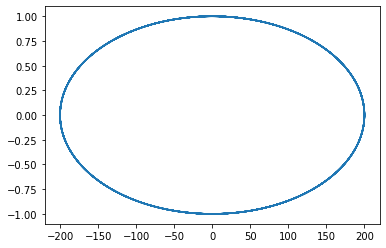

In [ ]:
t = data.t
dt = t[1]-t[0]
xt = data.x
yt = data.y
plt.plot(xt, yt)

In [ ]:
# Construimos la matriz de derivadas
derivs = ...

# Librería de funciones hasta el orden que querramos
theta = ...

# Definimos el tipo de regresión lineal
alpha_reg = ...
clf = linear_model.Lasso(alpha=alpha_reg, max_iter=100000000,
                         fit_intercept=False, normalize=False)

# Hacemos el ajuste
clf.fit(theta, derivs)
print(clf.coef_)